In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf

In [ ]:
df_train = pd.read_csv("train.tsv", sep='\t')
df_test = pd.read_csv("test.tsv", sep='\t', usecols=['urlid','boilerplate'])

FileNotFoundError: ignored

In [ ]:
df_train.head()

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,"{""title"":""IBM Sees Holographic Calls Air Breat...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,0.443783,0.0,0,0.090774,0,0.245831,0.003883,1,1,24,0,5424,170,8,0.152941,0.079130,0
1,http://www.popsci.com/technology/article/2012-...,8471,"{""title"":""The Fully Electronic Futuristic Star...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,0.468649,0.0,0,0.098707,0,0.203490,0.088652,1,1,40,0,4973,187,9,0.181818,0.125448,1
2,http://www.menshealth.com/health/flu-fighting-...,1164,"{""title"":""Fruits that Fight the Flu fruits tha...",health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,0.525448,0.0,0,0.072448,0,0.226402,0.120536,1,1,55,0,2240,258,11,0.166667,0.057613,1
3,http://www.dumblittleman.com/2007/12/10-foolpr...,6684,"{""title"":""10 Foolproof Tips for Better Sleep ""...",health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,0.480725,0.0,0,0.095861,0,0.265656,0.035343,1,0,24,0,2737,120,5,0.041667,0.100858,1
4,http://bleacherreport.com/articles/1205138-the...,9006,"{""title"":""The 50 Coolest Jerseys You Didn t Kn...",sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,0.446143,0.0,0,0.024908,0,0.228887,0.050473,1,1,14,0,12032,162,10,0.098765,0.082569,0


In [ ]:
df_train['alchemy_category'].value_counts()

?                     2342
recreation            1229
arts_entertainment     941
business               880
health                 506
sports                 380
culture_politics       343
computer_internet      296
science_technology     289
gaming                  76
religion                72
law_crime               31
unknown                  6
weather                  4
Name: alchemy_category, dtype: int64

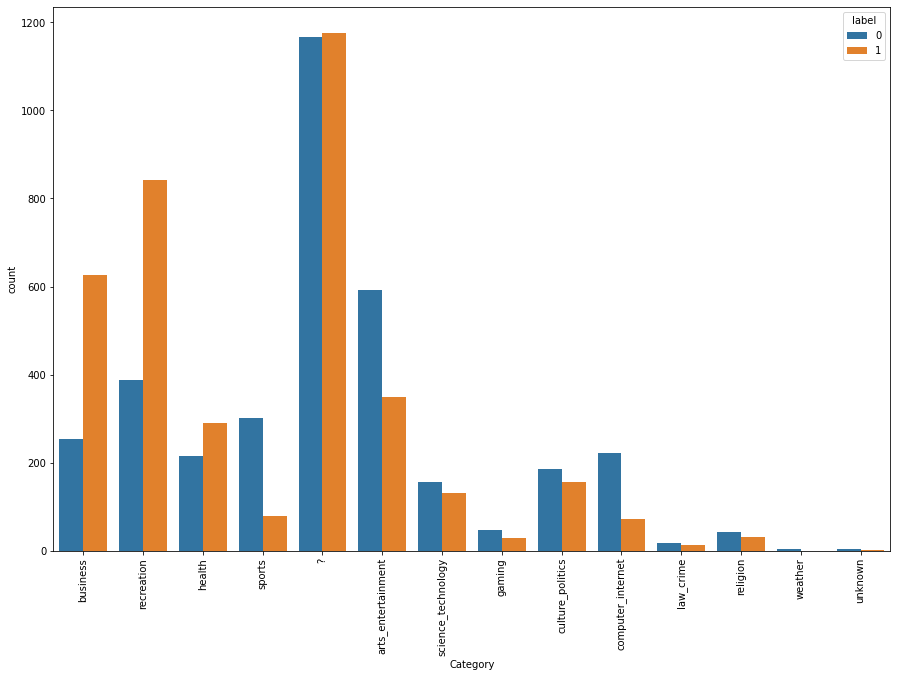

In [ ]:
plt.figure(figsize=(15,10))
sns.countplot(x=df_train['alchemy_category'],hue=df_train['label']);
plt.xlabel('Category');
plt.xticks(rotation=90);

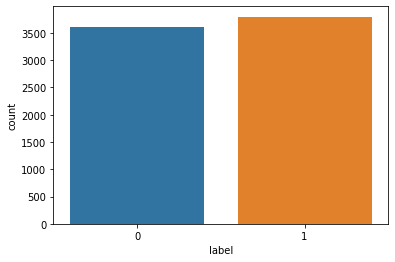

In [ ]:
sns.countplot(x=df_train['label'])

In [ ]:
df_train['boilerplate'].replace(to_replace=r'"title":', value='', regex=True, inplace=True)
df_train['boilerplate'].replace(to_replace=r'"body":', value='', regex=True, inplace=True)
df_train['boilerplate'].replace(to_replace=r'"url":', value='', regex=True, inplace=True)
df_train['boilerplate'] = df_train['boilerplate'].str.lower()


df_test['boilerplate'].replace(to_replace=r'"title":', value='', regex=True, inplace=True)
df_test['boilerplate'].replace(to_replace=r'"body":', value='', regex=True, inplace=True)
df_test['boilerplate'].replace(to_replace=r'"url":', value='', regex=True, inplace=True)
df_test['boilerplate'] = df_test['boilerplate'].str.lower() 


In [ ]:
df_train['boilerplate'][0]

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.5MB 7.8MB/s 
     |████████████████████████████████| 901kB 46.6MB/s 
     |████████████████████████████████| 3.3MB 48.3MB/s 


In [ ]:
from transformers import AutoTokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
SEQ_LEN = 512 # bert base model can handle length of 512

Xids = np.zeros((df_train.shape[0], SEQ_LEN))
Xmask = np.zeros((df_train.shape[0], SEQ_LEN))
y = np.zeros((df_train.shape[0], 1))

Xids_test = np.zeros((df_test.shape[0], SEQ_LEN))
Xmask_test = np.zeros((df_test.shape[0], SEQ_LEN))

print(Xids.shape)
y

In [ ]:
for i,sequence in enumerate(df_train['boilerplate']):
  tokens = tokenizer.encode_plus(sequence, max_length=SEQ_LEN, padding="max_length",add_special_tokens=True,
                                 truncation=True,return_token_type_ids=False,
                                 return_attention_mask=True, return_tensors='tf')
  
  Xids[i,:],Xmask[i,:],y[i,0] = tokens["input_ids"], tokens["attention_mask"], df_train.loc[i,'label']


for i,sequence in enumerate(df_test['boilerplate']):
  tokens = tokenizer.encode_plus(sequence, max_length=SEQ_LEN, padding="max_length", add_special_tokens=False,
                                 truncation=True,return_token_type_ids=False,
                                 return_attention_mask=True,return_tensors='tf')
  Xids_test[i,:],Xmask_test[i,:] = tokens["input_ids"], tokens["attention_mask"]

In [ ]:
Xids.shape

(7395, 512)

In [ ]:
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((Xids,Xmask,y))

def map_func(input_ids,mask,labels):
  return {"input_ids":input_ids, "attention_mask":mask}, labels

dataset = dataset.map(map_func)
dataset = dataset.shuffle(100000).batch(32).prefetch(1000)

DS_size = len(list(dataset))

train = dataset.take(round(DS_size*0.85))
valid = dataset.skip(round(DS_size*0.85))

In [ ]:
dataset_test = tf.data.Dataset.from_tensor_slices((Xids_test,Xmask_test))

def map_func_test(input_ids,mask):
  return {"input_ids":input_ids, "attention_mask":mask}

dataset_test = dataset_test.map(map_func_test)
dataset_test = dataset_test.batch(32).prefetch(1000) 

In [ ]:
from transformers import TFDistilBertModel, DistilBertConfig
distil_bert = "distilbert-base-uncased"

config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states = False
transformer_model = TFDistilBertModel.from_pretrained(distil_bert, config=config)

input_ids_in = tf.keras.layers.Input(shape=(SEQ_LEN,), name="input_ids", dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(SEQ_LEN,), name="attention_mask", dtype='int32')

embedding_layer = transformer_model(input_ids_in,attention_mask=input_masks_in)[0]

X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True, dropout=0.1,
                                                       recurrent_dropout=0.1))(embedding_layer)
X = tf.keras.layers.GlobalMaxPool1D()(X) 
X = tf.keras.layers.Dense(50, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(1, activation='sigmoid')(X)
model = tf.keras.Model(inputs=[input_ids_in, input_masks_in] ,outputs=X) 

for layer in model.layers[:3]:
  layer.trainable= False

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inpuut_ids (InputLayer)         [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_1 (TFDisti TFBaseModelOutput(la 66362880    inpuut_ids[0][0]                 
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 512, 100)     327600      tf_distil_bert_model_1[0][0] 

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer='adam', metrics=[tf.metrics.AUC(), tf.metrics.Precision(), tf.metrics.Recall()])

In [ ]:
history = model.fit(train, validation_data=valid, epochs=3)

Epoch 1/3
197/197 [==============================] - 775s 4s/step - loss: 0.4762 - auc_1: 0.8490 - precision_1: 0.8278 - recall_1: 0.7420 - val_loss: 0.4704 - val_auc_1: 0.8677 - val_precision_1: 0.8675 - val_recall_1: 0.7094
Epoch 2/3
197/197 [==============================] - 763s 4s/step - loss: 0.4479 - auc_1: 0.8690 - precision_1: 0.8349 - recall_1: 0.7820 - val_loss: 0.3939 - val_auc_1: 0.9094 - val_precision_1: 0.8383 - val_recall_1: 0.8428
Epoch 3/3
197/197 [==============================] - 764s 4s/step - loss: 0.4266 - auc_1: 0.8818 - precision_1: 0.8468 - recall_1: 0.7965 - val_loss: 0.3947 - val_auc_1: 0.9034 - val_precision_1: 0.8657 - val_recall_1: 0.8155


In [ ]:
predictions = model.predict(dataset_test)

In [ ]:
predictions

array([[0.9459317 ],
       [0.19947755],
       [0.44920707],
       ...,
       [0.41294202],
       [0.7780117 ],
       [0.86948454]], dtype=float32)

In [ ]:
input_x = tf.data.Dataset.from_tensor_slices((Xids,Xmask,y))

def map_func(input_ids, mask,labels):
  return {"input_ids":input_ids, "attention_mask":mask}

input_x = input_x.map(map_func)
input_x = input_x.shuffle(100000).batch(32).prefetch(1000)

y_true = y


In [ ]:
y_true

In [ ]:
y_pred = model.predict(dataset)
y_pred

array([[0.25251627],
       [0.18411192],
       [0.6950645 ],
       ...,
       [0.9642527 ],
       [0.34171322],
       [0.19108213]], dtype=float32)

In [ ]:
y_pred = np.round(y_pred)
y_pred

array([[0.],
       [0.],
       [1.],
       ...,
       [1.],
       [0.],
       [0.]], dtype=float32)

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.49      0.52      0.51      3599
         1.0       0.52      0.49      0.50      3796

    accuracy                           0.50      7395
   macro avg       0.50      0.50      0.50      7395
weighted avg       0.50      0.50      0.50      7395



In [ ]:
df_test['label'] = np.round(predictions)

df_test.to_csv('submission.csv', columns=['urlid', 'label'], index=False)

In [ ]:
# 0.78 efficiency